In [1]:
!pip install matplotlib
#mc cp s3/tordjx ummt --recursive

In [2]:
#%%
from BigModel import *
from Pipeline import *
from BigModelTrainer import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 50

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size)
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head = 4 
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 196
dropout = 0.1
activation = nn.Softmax(dim=2)
embedding_dim = 196
d_model = 196
model = Modèle (n_token_fr, n_token_en, d_model, n_head, num_encoder_layers, num_decoder_layers, dim_feedforward,dropout, activation, vocab_fr["TOKEN_VIDE"], vocab_en["TOKEN_VIDE"] )
#IF WE WANT TO LOAD PREVIOUSLY TRAINED MODEL
# model_en.load_state_dict(torch.load("model_en"))
# model_fr.load_state_dict(torch.load("model_fr"))

In [3]:
# val_features  = np.load(fs.open('tordjx/val-resnet50-res4frelu.npy'))
# train_features  = np.load(fs.open('tordjx/train-resnet50-res4frelu.npy'))
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
val_features = np.load("tordjx/val-resnet50-res4frelu.npy")

8.671883583068848
8.791688919067383
8.791549682617188
8.791682243347168
8.79167652130127
8.671904563903809
8.791690826416016
8.671903610229492
8.671894073486328
8.791679382324219
8.671893119812012
8.671879768371582
8.671894073486328
8.671895027160645
8.791552543640137
8.67187786102295
8.791548728942871
8.7916898727417
8.671894073486328
8.671893119812012
8.791692733764648
8.791686058044434
8.671875
8.671876907348633
8.671875953674316
8.671903610229492
8.671896934509277
8.791681289672852
8.791686058044434
8.671906471252441
8.671876907348633
8.79167652130127
8.79168701171875
8.671897888183594
8.791688919067383
8.671895980834961
8.791681289672852
8.791548728942871
8.791563987731934
8.671904563903809
8.671894073486328
Iteration : 0 batch numéro : 40 en 1310 ms par itération, moyenne loss tensor(7.1565, grad_fn=<DivBackward0>)
8.791682243347168
8.671873092651367
8.791686058044434
8.791681289672852
8.671904563903809
8.791691780090332
8.7915678024292
8.791681289672852
8.671896934509277
8.67187

KeyboardInterrupt: 

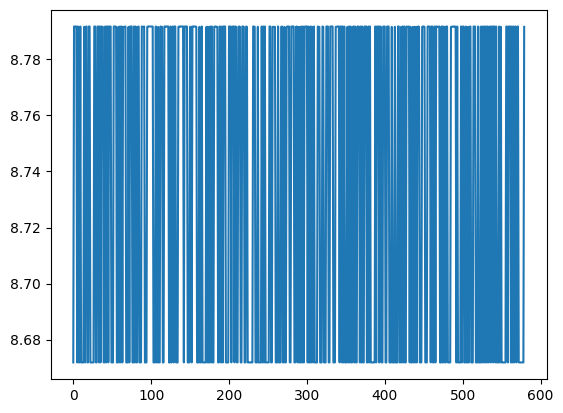

In [4]:

train_features_reshape= torch.from_numpy(train_features.reshape(train_features.shape[0]//batch_size ,batch_size ,1024, 196)).to(dtype = torch.float32)
#Est ce que cette commande est réellement safe ? Demander !
train_data_fr = [tokenized_fr, train_features_reshape]
train_data_en = [tokenized_en, train_features_reshape]
# Y=train_auto_encoding(model_fr,tokenized_fr)
# Y=train_auto_encoding(model_en,tokenized_en)
# Y= cycle_consistency_train(model_fr,model_en,tokenized_fr,tokenized_en)
mixed_train(model,train_data_fr,train_data_en,200,50,[1/3,2/3], True)
# mixed_train(model,tokenized_fr,tokenized_en,200,50,[1/3,1/3], False)

In [12]:
#%%
def tensor_to_sentence(output,inv_dic):
    result = [inv_dic[int(x)] for x in output]
    sentence = ""
    for word in result : 
        if word == "DEBUT_DE_PHRASE" :
            pass
        elif '@@' in word: 
            sentence+=word[:-2]
        elif word == "FIN_DE_PHRASE" :
            break 
        else :
            sentence+=word +" "
    return sentence

def traduit(model,text_data,features, inv_map):
    model.eval()
    output = torch.argmax(model('Cycle', 'B', text_data,True,features),dim = 2)[j]
    return tensor_to_sentence(output.view(-1),inv_map)

i = np.random.randint(len(tokenized_en)//50)
j = np.random.randint(50)
text_data,features = get_batch(train_data_en, i,True)

print("Phrase à traduire : \n" + tensor_to_sentence(text_data[j],inv_map_en)+ "\n Phrase traduite : \n "+ traduit(model,text_data,features, inv_map_fr))


#%%

Phrase à traduire : 
a young man is walking through a busy street beside a mall . 
 Phrase traduite : 
 nageuse cuisinier costumjuste carrejuste jardinterre déploymotifs ruissjardintransdéploymaintenance frappé signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signalisation signa

In [ ]:
torch.save(model_fr.state_dict(), "model_fr")
torch.save(model_en.state_dict(), "model_en")
import os
import s3fs
import pandas
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
fs.upload("model_fr","tordjx/model_fr")
fs.upload("model_en","tordjx/model_fr")

In [ ]:
data ,_= get_batch(tokenized_fr, 0 )
model_fr(data)